# CS5830 Naive Bayes
Chetan Birthare, Zion Steiner

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
import praw

### Subreddits
* AskReddit
* WritingPrompts
* TIL
* WorldNews
* UnethicalLifeProTips

### Procedure
1. Collect the 500 top posts titles from each subreddit.
2. Construct feature sets from post title
    * Count Matrix
    * Tfidf Matrix
3. Compare naive bayes performance

In [3]:
# Init API with credentials
reddit = praw.Reddit(client_id='',
                     client_secret='', password='',
                     user_agent='', username='')

In [14]:
subs = ['AskReddit', 'WritingPrompts', 'todayilearned', 'worldnews', 'UnethicalLifeProTips']

In [5]:
# Collect post titles
df_title = pd.DataFrame(columns=['subreddit', 'title'])
for sub in subs:
    subreddit = reddit.subreddit(sub)
    for post in subreddit.top('all', limit=500):
        df = df.append({'subreddit': sub,
                        'title': post.title.lower()}, ignore_index=True)

In [33]:
# Remove stopwords (a, the, that, etc) from titles

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

df_title = pd.read_csv('data/titles.csv', index_col=0)

df_title['cleaned_title'] = df_title['title'].apply(lambda title: ' '.join([word for word in title.split() if word not in stop_words]))
df_title.to_csv('data/titles.csv')
df_title.sample(10)

[nltk_data] Downloading package stopwords to /home/zion/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,subreddit,title,word_count,cleaned_title
2314,UnethicalLifeProTips,ulpt: if you’re new to a city and need to find...,29,"ulpt: you’re new city need find drugs, check c..."
1074,todayilearned,til that prince william and prince harry pulle...,51,til prince william prince harry pulled prank g...
687,WritingPrompts,[wp] you're an evil overlord who has ruled ove...,52,[wp] evil overlord ruled dominion ages. secret...
1833,worldnews,u.s. does not join plastic waste agreement sig...,11,u.s. join plastic waste agreement signed 187 c...
2136,UnethicalLifeProTips,ulpt: if you're headed to europe from outside ...,41,"ulpt: headed europe outside eu, make fake stud..."
41,AskReddit,the words 'low battery' appear right before yo...,38,"words 'low battery' appear right eyes, take vr..."
1090,todayilearned,til that after visiting a prison in norway tha...,40,til visiting prison norway treated prisoners h...
1597,worldnews,porn sites in hong kong shut down to encourage...,12,porn sites hong kong shut encourage people pro...
267,AskReddit,what are some of the most interesting 24/7 liv...,16,interesting 24/7 live-streaming webcams watch ...
2258,UnethicalLifeProTips,ulpt: post your apartment online for rent and ...,24,ulpt: post apartment online rent pretend prope...


In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate

def naive_bayes(X, y, report=True):
    results = cross_validate(estimator=MultinomialNB(),
                         X=X,
                         y=y,
                         scoring=['f1_weighted', 'precision_weighted', 'recall_weighted', 'accuracy'], 
                         cv=10, 
                         return_train_score=False)
    
    for metric in results.keys():
        results[metric] = np.mean([result for result in results[metric] if result > 0])
    
    # Confusion matrix
    y_true = y

    clf = MultinomialNB()
    clf.fit(X, y_true)
    y_pred = clf.predict(X)

    if report:
        plt.figure(figsize=(8, 8))
        ax = sns.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred, labels=subs), index=subs, columns=subs), annot=True, fmt='')
        ax.set_title('Confusion Matrix')

    f1 = sklearn.metrics.f1_score(y_true, y_pred, average='macro')
    
    if report:
        print('Results')
        print('--------------')
        for metric, value in results.items():
            print(f'{metric.title()}, {value}')
        print()
        print('Entire Dataset f1: ', f1)
    
    return f1

Results
--------------
Fit_Time, 0.005160665512084961
Score_Time, 0.002947688102722168
Test_F1_Weighted, 0.9031263488081578
Test_Precision_Weighted, 0.9152243789951255
Test_Recall_Weighted, 0.9048
Test_Accuracy, 0.9048

Entire Dataset f1:  0.9823502444230277


[nltk_data] Downloading package stopwords to /home/zion/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0.9823502444230277

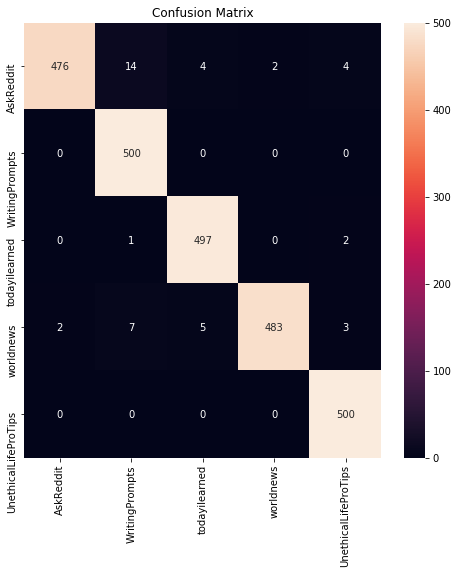

In [24]:
# Count Matrix (Naive features, uncleaned data)
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

count_matrix = CountVectorizer().fit_transform(df_title['title'])
naive_bayes(count_matrix, df_title['subreddit'])

[nltk_data] Downloading package stopwords to /home/zion/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Results
--------------
Fit_Time, 0.005060434341430664
Score_Time, 0.002843213081359863
Test_F1_Weighted, 0.877907002256101
Test_Precision_Weighted, 0.8908772091612732
Test_Recall_Weighted, 0.8827999999999999
Test_Accuracy, 0.8827999999999999

Entire Dataset f1:  0.9751870758718052


0.9751870758718052

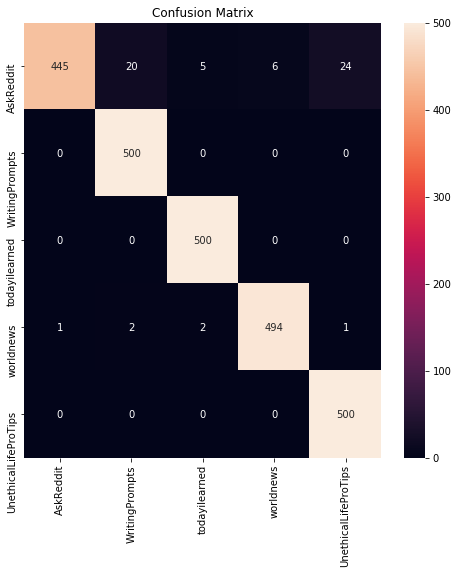

In [34]:
# Count Matrix (Naive features, cleaned data)
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

count_matrix = CountVectorizer().fit_transform(df_title['cleaned_title'])
naive_bayes(count_matrix, df_title['subreddit'])

Results
--------------
Fit_Time, 0.005326509475708008
Score_Time, 0.0030402898788452148
Test_F1_Weighted, 0.8772561295160084
Test_Precision_Weighted, 0.8906171476290297
Test_Recall_Weighted, 0.8784000000000001
Test_Accuracy, 0.8784000000000001

Entire Dataset f1:  0.978004969729166


0.978004969729166

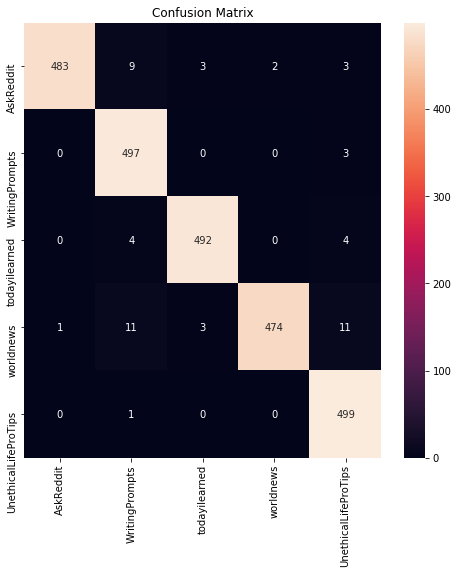

In [25]:
# Term Frequency-Inverse Document Frequency Matrix
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer().fit_transform(df_title['title'])
naive_bayes(tfidf, df_title['subreddit'])

Results
--------------
Fit_Time, 0.00493464469909668
Score_Time, 0.0029184818267822266
Test_F1_Weighted, 0.8437718602232145
Test_Precision_Weighted, 0.8583724659599703
Test_Recall_Weighted, 0.8459999999999999
Test_Accuracy, 0.8459999999999999

Entire Dataset f1:  0.9810756305251417


0.9810756305251417

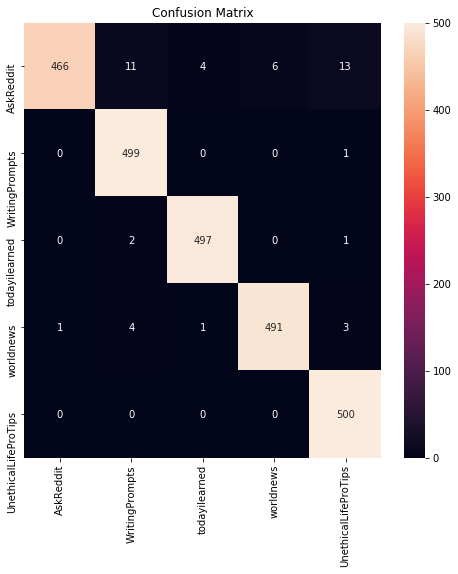

In [35]:
# Term Frequency-Inverse Document Frequency Matrix
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer().fit_transform(df_title['cleaned_title'])
naive_bayes(tfidf, df_title['subreddit'])

### It seems like word count works slightly better than *tfidm*. Why?

It's possible that important information is lost when the *tfidm* is taken of short documents. Because there are fewer words, maybe values assigned to certain words of importance are overly penalized in *tfidm*. This might lead to a disproportiate effect related to corpus length. 

One example of certain words being overly penalized is words whose interpretation is context-dependent. Context-dependent words might occur more frequently than other words in a corpus because they can be used to have different meanings. However, they are separated from their semantic meaning when counted. The information about their relevance across the corpus is then disproportionately penalized by the document inverse term.

To test this, model performance on both feature sets was collected for post titles stratified by length in words.

/home/zion/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


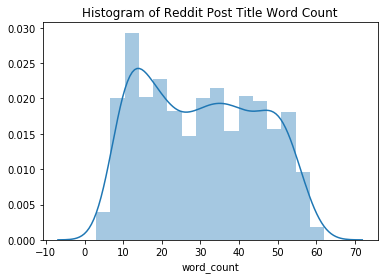

In [14]:
df_title['word_count'] = df_title['title'].str.split().apply(lambda x: len(x))
df_title.to_csv('data/titles.csv')

sns.distplot(df_title['word_count']).set_title('Histogram of Reddit Post Title Word Count')
plt.savefig('imgs/wordCountHist.png')

The word count distribution looks uniformly spread with a mode somewhere between 10-15 words. We'll partition the data by word count ranges of 10.

In [29]:
df_title['word_count'].max() - df_title['word_count'].min()

59

Six groups.

In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import warnings

warnings.filterwarnings(action='ignore')

df_title.sort_values(by='word_count', inplace=True)

count_f1 = [[], []]
tfidf_f1 = [[], []]

inc = 10
for x in range(0, 51, inc):
    data = df_title.loc[(df_title['word_count'] >= x) & (df_title['word_count'] < x+10)]
    
    count_matrix = CountVectorizer().fit_transform(data['title'])
    count_f1[0].append(x)
    count_f1[1].append(naive_bayes(count_matrix, data['subreddit'], report=False))

    tfidf = TfidfVectorizer().fit_transform(data['title'])
    tfidf_f1[0].append(x)
    tfidf_f1[1].append(naive_bayes(tfidf, data['subreddit'], report=False))

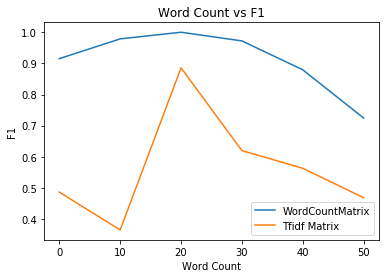

In [31]:
# Plot
# fig, axs = plt.subplots((2, 1), figsize=(8, 8))
ax = sns.lineplot(x=count_f1[0], y=count_f1[1], label='WordCountMatrix')
ax = sns.lineplot(x=tfidf_f1[0], y=tfidf_f1[1], ax=ax, label='Tfidf Matrix')
ax.set_title('Word Count vs F1')
ax.set(xlabel='Word Count', ylabel='F1')
ax.legend()
plt.savefig('imgs/wordCountVF1.png')

It looks like choice of feature set does effect different word count ranges differently. However, the exact mechanism is unknown. 

### Future work
* It would be interesting to compare these results to another test but on longer documents. 
* Would average word length or number of words in title be effectice predictive features for subreddit? 

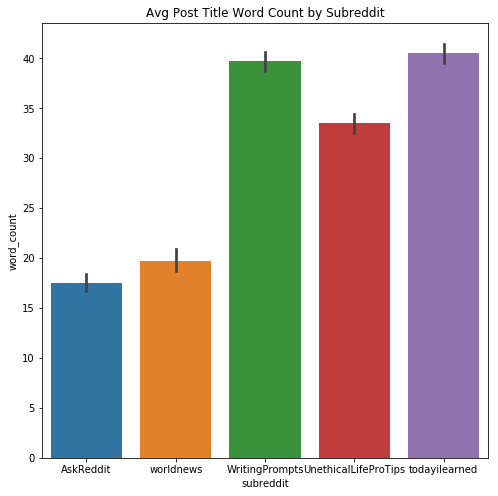

In [32]:
plt.figure(figsize=(8, 8))
sns.barplot(x='subreddit', y='word_count', data=df_title).set_title('Avg Post Title Word Count by Subreddit')
plt.savefig('imgs/word_count_bar.png')

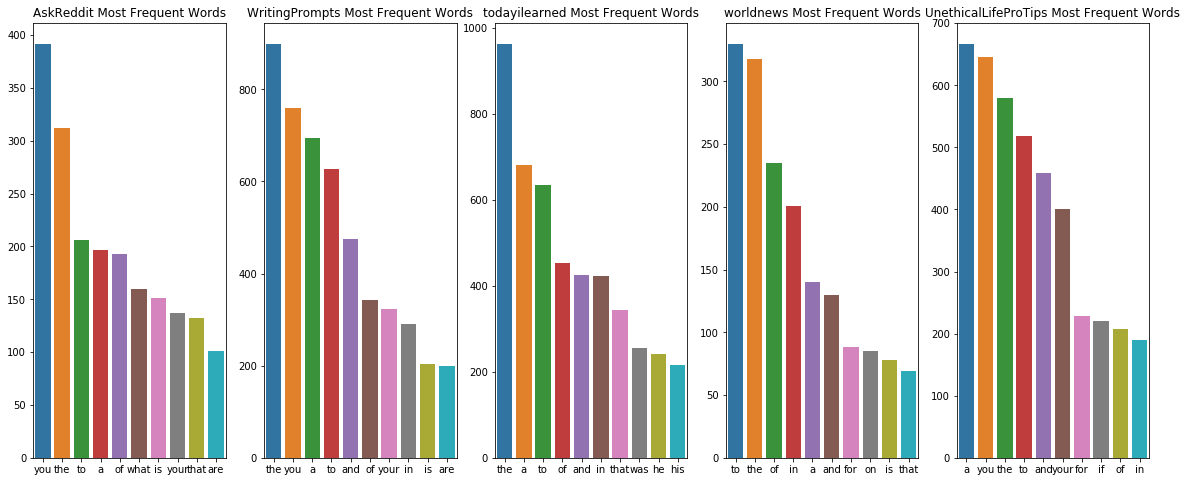

In [33]:
# Top ten words by sub
from collections import defaultdict

fig, axs = plt.subplots(1, 5, figsize=(20, 8))
for i,ax in enumerate(axs):
    data = df_title.loc[df_title['subreddit'] == subs[i]]
    
    corpus = ''
    for title in data['title']:
        corpus += title
    
    word_freq_dict = defaultdict(int)
    for word in corpus.split():
        word_freq_dict[word] += 1
        
    x = []
    y = []
    
    for word, count in sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True):
        x.append(word)
        y.append(count)        
    
    sns.barplot(x=x[:10], y=y[:10], ax=axs[i]).set_title(f'{subs[i]} Most Frequent Words')
    
plt.savefig('imgs/ind_word_count_bar.png')

Mostly useless words. Removing stopwords might make this more informative.

[nltk_data] Downloading package stopwords to /home/zion/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


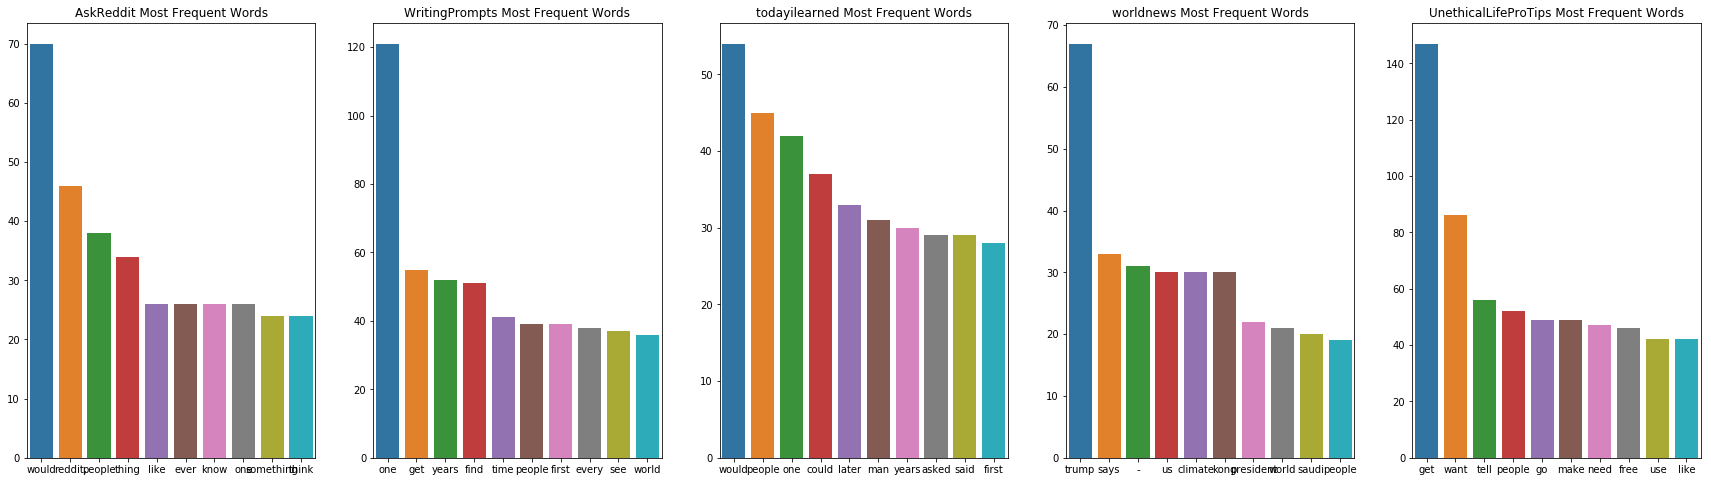

In [36]:
# Top ten words by sub (no stopwords)
from collections import defaultdict
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

fig, axs = plt.subplots(1, 5, figsize=(30, 8))
for i,ax in enumerate(axs):
    data = df_title.loc[df_title['subreddit'] == subs[i]]
    
    corpus = ''
    for title in data['title']:
        corpus += title
    
    word_freq_dict = defaultdict(int)
    for word in [word for word in corpus.split() if word not in stop_words]:
        word_freq_dict[word] += 1
        
    x = []
    y = []
    
    for word, count in sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True):
        x.append(word)
        y.append(count)        
    
    sns.barplot(x=x[:10], y=y[:10], ax=axs[i]).set_title(f'{subs[i]} Most Frequent Words')
    
plt.savefig('imgs/ind_word_count_bar_no_stopwords.png')